In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from xdgmm import XDGMM

from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

from test_plots import *

'''
Due to AstroML still using the deprecated GMM class from 
scikit-learn (instead of GaussianMixture), this demo will 
throw numerous errors whenever the XDGMM object calls 
an AstroML method, such as fit. The lines below will 
suppress these warnings; comment them out to see everything.

This XDGMM class has been updated to use GaussianMixture 
instead of GMM when necessary, but since it uses an AstroML
XDGMM object to store and manipulate the model, it is 
dependent on AstroML. These warnings will continue to occur 
until the XDGMM class from AstroML has been updated.
'''
import warnings
warnings.filterwarnings('ignore')

Next, generate some data to use for our fitting and plotting.

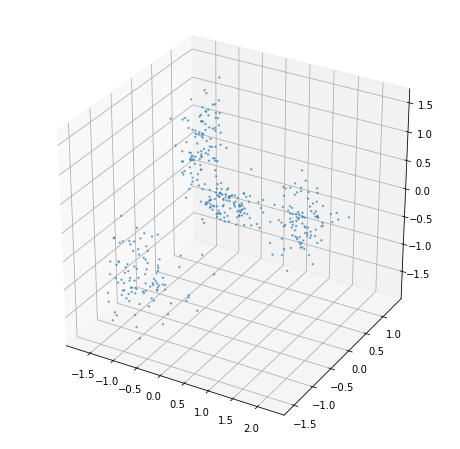

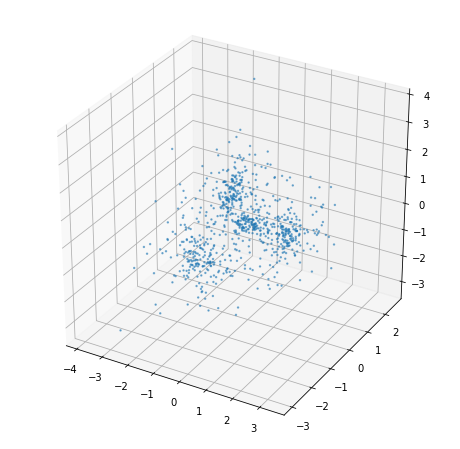

In [2]:
## Generate synthetic data
N,D = 100, 3 # number of points and dimenstinality

if D == 2:
    #set gaussian ceters and covariances in 2D
    means = np.array([[1.5, 0.0],
                      [0, 0],
                      [-1.0, -1.0],
                      [-1.0, 0.5]])
    covs = np.array([np.diag([0.01, 0.01]),
                     np.diag([0.08, 0.01]),
                     np.diag([0.01, 0.05]),
                     np.diag([0.03, 0.07])])
elif D == 3:
    # set gaussian ceters and covariances in 3D
    means = np.array([[1.5, 0.0, 0.0],
                      [0.0, 0.0, 0.0],
                      [-1.0, -1.0, -1.0],
                      [-1.0, 0.5, 0.5]])
    covs = np.array([np.diag([0.05, 0.05, 0.10]),   #np.diag()输出矩阵的对角线元素,或将一维数组变成以一维数组为对角线元素的矩阵
                     np.diag([0.08, 0.03, 0.03]),
                     np.diag([0.20, 0.05, 0.15]),
                     np.diag([0.03, 0.07, 0.15]),])
n_gaussians = means.shape[0]    #shape结果为显示矩阵为(n,m)如(1,4), shape[0]显示列(第二维的长度)

points = []
for i in range(len(means)):
   x = np.random.multivariate_normal(means[i], covs[i], N )
   points.append(x)
X = np.concatenate(points)

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection='3d')
axes.scatter(X[:, 0], X[:, 1], X[:, 2], s = 2.0, alpha = 0.5)


# add noise to get the "observed" distribution
dx = 0.5 + 0.5 * np.random.random(400)
dy = 0.5 + 0.5 * np.random.random(400)
dz = 0.5 + 0.5 * np.random.random(400)

x_noise = X[:, 0].T + np.random.normal(0, dx)
y_noise = X[:, 1].T + np.random.normal(0, dy)
z_noise = X[:, 2].T + np.random.normal(0, dz)
X_noise = np.vstack([x_noise, y_noise, z_noise]).T

X_all = np.concatenate((X,X_noise), axis=0)
fig_noise = plt.figure(figsize=(8, 8))
axes_noise = fig_noise.add_subplot(111, projection='3d')
axes_noise.scatter(X_all[:, 0], X_all[:, 1], X_all[:, 2], s = 2.0, alpha = 0.5)

Xerr = np.zeros(X.shape + X.shape[-1:])
# diag = np.arange(X.shape[-1])
# Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

## Component Number Selection

We could fit this data directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way this can be determined is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

In [3]:
# Instantiate an XDGMM model:
xdgmm = XDGMM(method='Bovy')

# Define the range of component numbers, and get ready to compute the BIC for each one:
param_range = np.array([1,2,3,4,5,6,7])

# Loop over component numbers, fitting XDGMM model and computing the BIC:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X, Xerr, param_range, no_err=True)

N = 1 , BIC = 2363.5742528245623
N = 2 , BIC = 1934.092735741362
N = 3 , BIC = 1687.1826547961641
N = 4 , BIC = 1484.6204707958952
N = 5 , BIC = 1538.7483466629265
N = 6 , BIC = 1586.9640401514953
N = 7 , BIC = 1634.397334012159


<Figure size 432x288 with 0 Axes>

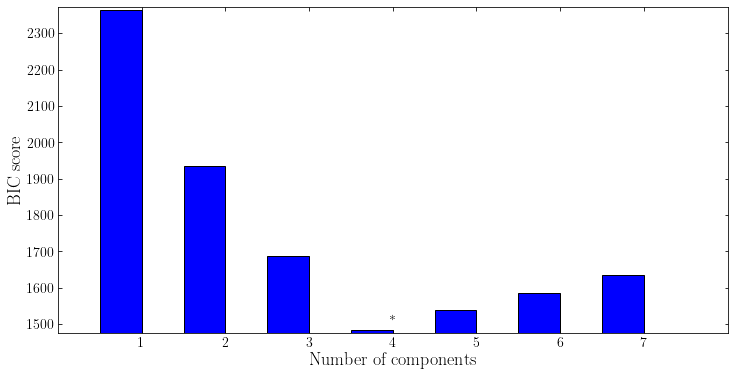

In [4]:
plot_bic(param_range, bic, optimal_n_comp)

## Model Fitting

Now that we know the best number of components to use, we can fit the data. First set the number of components, then perform the fit.

In [9]:
xdgmm.n_components = optimal_n_comp
xdgmm = xdgmm.fit(X, Xerr)

xdgmm.save_model('test_model.fit')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

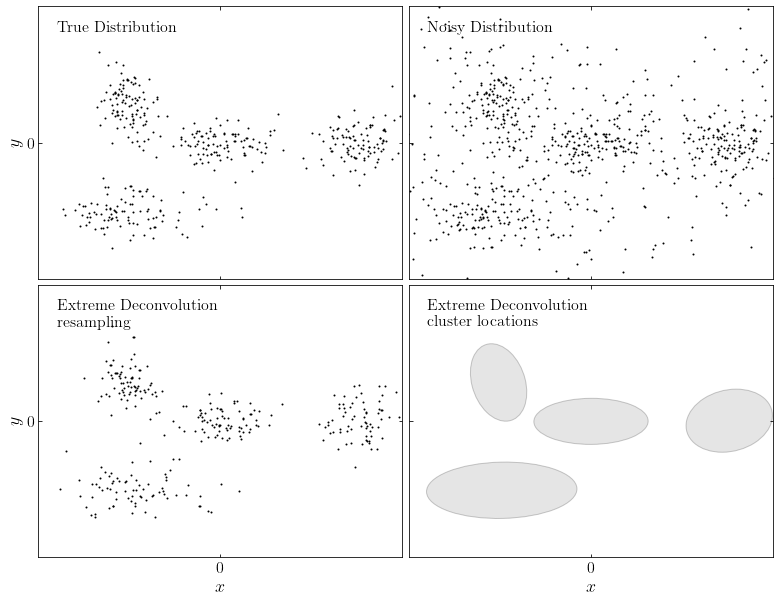

In [6]:
sample = xdgmm.sample(N*3)

plot_sample(X[:,0], X[:,1], X_all[:,0], X_all[:,1], sample, xdgmm)

In [52]:
def plot_sphere(w=0, center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1], ax=None):
    '''
        plot a sphere surface
        Input:
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
                    是椭球的分辨率
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2 * np.pi, 30)   #np.linspace 取等差数列
    v = np.linspace(0, np.pi, 30)
    x = r[0] * np.outer(np.cos(u), np.sin(v))
    y = r[1] * np.outer(np.sin(u), np.sin(v))
    z = r[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    for i in range(len(x)):
        for j in range(len(x)):
            #[x[i, j], y[i, j], z[i, j]] = [x[i, j], y[i, j], z[i, j]] + center #spherical专用
            [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation.T) + center

    ax.plot_surface(x, y, z, alpha=0.3, linewidth=0)

    return ax

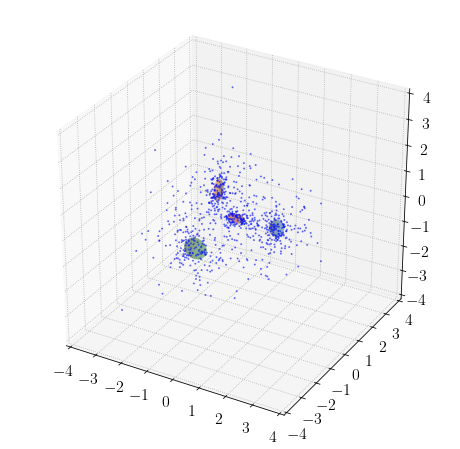

In [55]:
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection='3d')
axes.set_zlim3d(-4, 4)
axes.set_xlim3d(-4, 4)
axes.set_ylim3d(-4, 4)
# axes.view_init(-90, 90)
axes.scatter(X_all[:, 0], X_all[:, 1], X_all[:, 2], s = 1.0, alpha = 0.5)

for i in range(optimal_n_comp):
    covariances = xdgmm.V[i][:3, :3]
    v, u = np.linalg.eigh(covariances)
    r = np.sqrt(v)
    plot_sphere(xdgmm.weights[i], xdgmm.mu.T[:3,i], r, u, ax=axes)

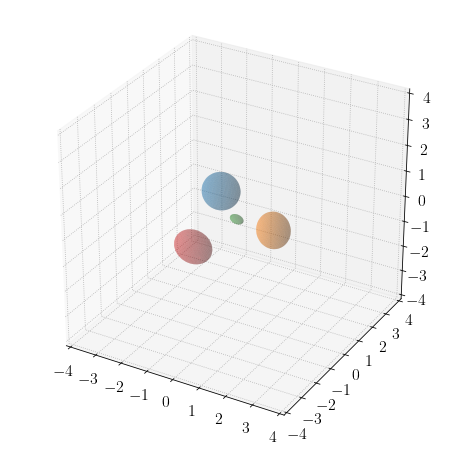

In [50]:
from sklearn.mixture import GaussianMixture
import visualization

gmm = GaussianMixture(n_components= 4, covariance_type='full')
gmm.fit(X_all)

figsk = plt.figure(figsize=(8, 8))
axessk = figsk.add_subplot(111, projection='3d')
axessk.set_zlim3d(-4, 4)
axessk.set_xlim3d(-4, 4)
axessk.set_ylim3d(-4, 4)

for i in range(0,4):
    covariances = gmm.covariances_[i][:3, :3]
    v, u = np.linalg.eigh(covariances)
    r = np.sqrt(v)
    plot_sphere(gmm.weights_[i], gmm.means_.T[:3,i], r, u, ax=axessk)

## Conditioning the Model

One of the key advantages of our implementation of the XDGMM class is that it contains a method for producing a model for the conditional PDF $P(x | y)$ from the original GMM model for the joint PDF $P(x, y)$. The conditional PDF is also a GMM with the same number of components, but with adjusted weights, means and variance. This is useful for predicting new $x$ values given test $y$ values: we simply sample from the conditioned model.

For our example dataset, let's assume that we have measured the $y$ value to be $1.5\pm0.05$. We can produce a new model for $x$ that is conditioned on $y=1.5\pm0.05$, and use that to sample values of $x$. When `condition()` is called, we set all parameters that we do not want included in the conditioning to `NaN`. The model can be conditioned on values either with uncertainties or without; to condition without uncertainty either do not pass an error array, or set all the uncertainties equal to $0$. If provided, the uncertainties are interpreted as being Gaussian and uncorrelated, and thus providing a simple $P(y)$ to be combined with the joint PDF. 

In [11]:
cond_X = np.array([np.nan, 1.5])
cond_Xerr = np.array([0.0,0.05])
cond_xdgmm = xdgmm.condition(X_input = cond_X,Xerr_input = cond_Xerr)

# Compare the conditioned model to the original:
print(xdgmm.weights)
print(cond_xdgmm.weights)
print("\n")
print(xdgmm.mu)
print(cond_xdgmm.mu)

[ 0.23782663  0.16762366  0.22383112  0.25412251  0.11659607]
[  2.23589696e-01   3.37482536e-10   5.86748256e-01   5.01464672e-02
   1.39515580e-01]


[[  5.47757846   2.99640361]
 [ 10.474094    11.00981852]
 [  3.72920772   1.84011374]
 [  7.66517037   5.96308349]
 [  2.42017046   0.91819368]]
[[ 4.36857525]
 [ 6.22877851]
 [ 3.4679643 ]
 [ 4.94409836]
 [ 2.38190858]]


Note how the number of components in the conditioned model is the same as in the original joint model, but that the weights of the components have changed, and the mu array is now 1-dimensional (since $y$ has been conditioned out).

A list of labels for each parameter in the dataset can also be stored in the XDGMM object, and then a dictionary object can be used to condition the model using the labels. This removes the need for the user to remember which index corresponds to which parameter. When using a dictionary, it is only necessary to pass values for the labels that you want to condition on. If floats are given with each label, then `condition()` assumes that these are data values and that the uncertainty is 0. If tuples are given, the function assumes that the tuples contain (data, uncertainty) pairs. The new, conditioned XDGMM object will retain the labels of any parameters that were not conditioned out. This functionality is demonstrated below.

If the data used to fit the XDGMM model are in the form of a Pandas DataFrame and the columns have been labelled, the XDGMM object will automatically save the column labels in the `labels` array for future use.

In [12]:
# First, set the labels in the XDGMM object
xdgmm.labels = np.array(['x','y'])

# The dictionary can pass either floats or tuples
cond_dict = {'y':(1.5,0.05)}
cond_xdgmm2 = xdgmm.condition(X_dict = cond_dict)

# Print the weights and means of the new model.
print(cond_xdgmm2.weights)
print(cond_xdgmm2.mu)
print(cond_xdgmm2.labels)

[  2.23589696e-01   3.37482536e-10   5.86748256e-01   5.01464672e-02
   1.39515580e-01]
[[ 4.36857525]
 [ 6.22877851]
 [ 3.4679643 ]
 [ 4.94409836]
 [ 2.38190858]]
['x']


As expected, the conditioning results are the same. Labels will also be saved to and read from files when the `save_model()` and `read_model()` functions are used. 

Below we plot the original Gaussian components in the $x-y$ plane, a blue line showing the condition $y=1.5$, and a red line showing the new conditional distribution for $x$ given $y=1.5\pm0.05$.

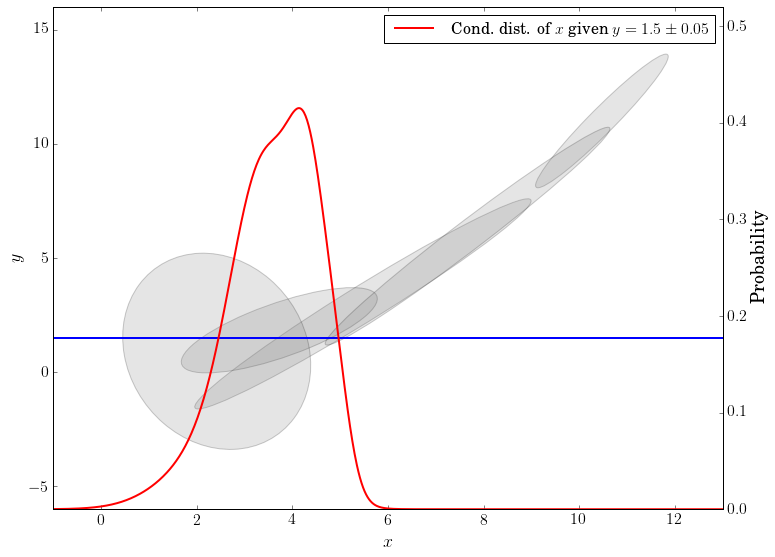

In [13]:
plot_cond_model(xdgmm, cond_xdgmm, 1.5)

If we sample 1000 points from this conditional distribution, we would get something like this:

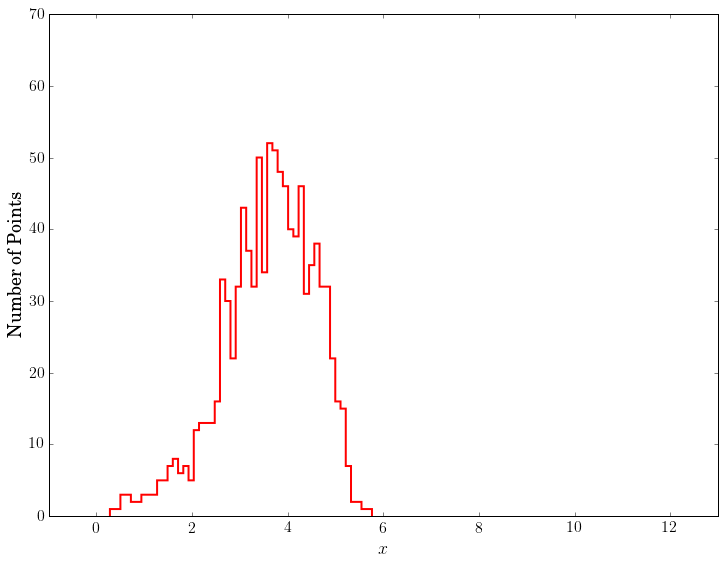

In [14]:
cond_sample = cond_xdgmm.sample(1000)
y = np.ones(1000)*1.5
plot_cond_sample(cond_sample,y)

## Conditional Prediction

As stated before, one potential use of a conditioned model is to create a "prediction engine" that can predict some parameters using an `XDGMM` model conditioned on known values of other parameters.

To demonstrate this, let's sample 1000 data points from our joint model to create a dataset to be compared with our predictions. Now, at the same $y$ values as this "observed" dataset, we'll condition the model on each $y$ value in turn, and draw a single predicted $x$ value. These predicted $x$'s should follow the same distribution as the observed $x$'s.

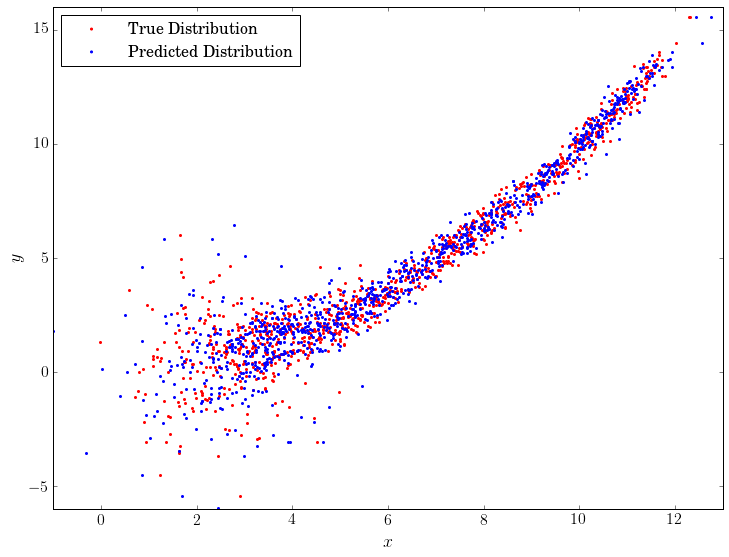

In [15]:
# Simulate a dataset:
true_sample = xdgmm.sample(1000)
true_x = true_sample[:,0]
y = true_sample[:,1]

# Predict x values given y values:
predicted_x = np.array([])
for this_y in y:
    # Specify y-conditioning to apply to P(x,y):
    on_this = np.array([np.nan,this_y])
    # Compute conditional PDF P(x|y):
    cond_gmm = xdgmm.condition(on_this)
    # Draw a sample x value from this PDF, and add it to the growing list
    predicted_x = np.append(predicted_x, cond_gmm.sample())

# Plot the two datasets, to compare the true x and the predicted x:
plot_conditional_predictions(y, true_x, predicted_x)